In [ ]:

# =========================
# RQ3 — SHAP & Regime-wise Stability (no training)
# =========================
# - loads baseline checkpoint & artifacts exported by RQ1/RQ2
# - computes SHAP on the regression forecaster (7-day log-return)
# - plots: global bars, beeswarm/bar (last step), sum-over-window bar,
#          time–feature heatmap, dependence plots
# - evaluates truth-based bull vs bear stability (Spearman, Jaccard@10)



# ---- Cell 0. Paths & minimal setup

import os, json, numpy as np, pandas as pd

project_path = os.getenv('PROJECT_PATH', '.')
ART = os.path.join(project_path, "artifacts")
RESULTS_ATTR = os.path.join(project_path, "results", "attributions")
RESULTS_FIG  = os.path.join(project_path, "results", "figures")
os.makedirs(RESULTS_ATTR, exist_ok=True)
os.makedirs(RESULTS_FIG, exist_ok=True)

# Small helper to save figures in both folders if needed
def savefig(path, fig=None, dpi=300):
    import matplotlib.pyplot as plt
    (fig or plt.gcf()).savefig(path, dpi=dpi, bbox_inches="tight")
    print("Saved:", path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
print("Current working dir:", os.getcwd())
print("project_path =", project_path)
print("ART folder exists:", os.path.isdir(ART))
if os.path.isdir(ART):
    print("Files in ART:", os.listdir(ART))
else:
    print("ART folder does not exist")


Current working dir: /content
project_path = /content/drive/MyDrive/nvda_rnn_forecasting
ART folder exists: True
Files in ART: ['Xp_all_minus_scaled.npy', 'Xp_all_plus_scaled.npy', 'Xp_all_minus_scaled_5pct.npy', 'Xp_all_plus_scaled_5pct.npy', 'shap_global_all.npy', 'shap_background.npy', 'X_test_unscaled.npy', 'y_test.npy', 'X_val_scaled.npy', 'test_regimes.csv', 'X_train_scaled.npy', 'X_test_scaled.npy', 'meta.json', 'baseline_lstm.keras', 'feature_scaler_standard.pkl', 'manifest.json', 'target_scaler_standard.pkl']


In [ ]:
import hashlib, joblib, shap
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from tensorflow.keras.models import load_model

def _sha256(p):
    h = hashlib.sha256()
    with open(p, "rb") as f:
        for chunk in iter(lambda: f.read(524288), b""): h.update(chunk)
    return h.hexdigest()

assert os.path.isdir(ART), f"Artifacts folder missing: {ART}"
manifest = json.load(open(os.path.join(ART, "manifest.json")))
meta     = json.load(open(os.path.join(ART, "meta.json")))
feat_names = meta["features"]
lookback   = int(meta["lookback"])
n_feats    = len(feat_names)

model_path = os.path.join(ART, "baseline_lstm.keras")
assert os.path.exists(model_path), "baseline_lstm.keras not found in artifacts"
if "files" in manifest and "baseline_model" in manifest["files"]:
    assert _sha256(model_path) == manifest["files"]["baseline_model"]["sha256"], "Model hash mismatch — wrong checkpoint?"

X_test = np.load(os.path.join(ART, "X_test_scaled.npy")).astype(np.float32)
y_test = np.load(os.path.join(ART, "y_test.npy"))
reg_df = pd.read_csv(os.path.join(ART, "test_regimes.csv"))
B      = np.load(os.path.join(ART, "shap_background.npy")).astype(np.float32)

assert len(y_test) == X_test.shape[0], "y_test length != X_test rows"
assert len(reg_df) == X_test.shape[0], "regimes rows != X_test rows"
assert X_test.shape[1] == lookback,    "X_test lookback (T) != meta lookback"
assert X_test.shape[2] == n_feats,     "X_test features (F) != meta feature count"
assert B.shape[1] == lookback and B.shape[2] == n_feats, "Background shape incompatible"

feat_scaler = joblib.load(os.path.join(ART, "feature_scaler_standard.pkl"))
if hasattr(feat_scaler, "n_features_in_"):
    assert feat_scaler.n_features_in_ == n_feats, "Scaler.n_features_in_ != feature count"
print("Integrity checks passed.")


Integrity checks passed.


In [ ]:
# ---- Cell 2. Explainer & helpers ----
model = load_model(model_path)
explainer = shap.GradientExplainer(model, B)

def shap_global(explainer, X):
    """
    Global per-feature importance (F,):
    mean over samples of sum(abs(phi)) across timesteps.
    """
    try:
        phi = explainer.shap_values(X, check_additivity=False)
    except TypeError:
        phi = explainer.shap_values(X)
    if isinstance(phi, list):
        phi = phi[0]
    phi = np.asarray(phi)

    if phi.ndim == 4 and phi.shape[-1] == 1:
        phi = phi[..., 0]
    assert phi.ndim == 3, f"Expected (N,T,F), got {phi.shape}"
    G = np.mean(np.sum(np.abs(phi), axis=1), axis=0)  # (F,)
    return np.asarray(G).reshape(-1)

def spearman_rho(a, b):
    return float(spearmanr(a, b).correlation)

def topk_jaccard(a, b, k=10):
    Ai = set(np.argsort(a)[-k:])
    Bi = set(np.argsort(b)[-k:])
    return len(Ai & Bi) / len(Ai | Bi)




In [ ]:
# ---- Cell 3. Baseline global SHAP on full test set ----
I_all = shap_global(explainer, X_test)
assert I_all.ndim == 1 and I_all.shape[0] == n_feats, f"I_all shape bad: {I_all.shape}"
np.save(os.path.join(ART, "shap_global_all.npy"), I_all)

(pd.DataFrame({"feature": feat_names, "importance": I_all})
   .sort_values("importance", ascending=False)
   .to_csv(os.path.join(RESULTS_ATTR, "rq3_shap_global_all.csv"), index=False))



/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(502, 40, 7))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 40, 7))']
  warnings.warn(msg)


Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/attributions/rq3_shap_global_bar_top10.png


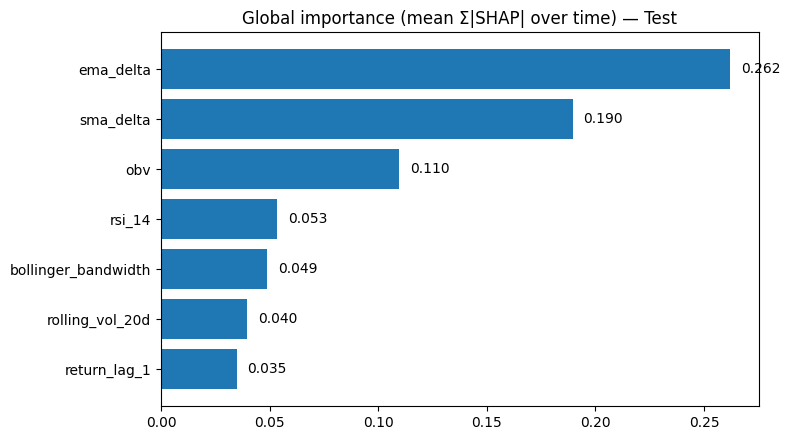

In [ ]:
# Plot: top-10 global bars (ascending)
order   = np.argsort(I_all)
topk    = min(10, n_feats)
top_idx = order[-topk:]   # <--- no [::-1]: ascending order (smallest to largest)

plt.figure(figsize=(8, 4.5))
bars = plt.barh([feat_names[i] for i in top_idx], I_all[top_idx])
plt.title("Global importance (mean Σ|SHAP| over time) — Test")

# Add data labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f"{width:.3f}", va='center', fontsize=10)

plt.tight_layout()
savefig(os.path.join(RESULTS_ATTR, "rq3_shap_global_bar_top10.png"))
plt.close()


In [ ]:
# ---- Cell 4. Detailed SHAP values for plots (beeswarm/bar/heatmap/dependence) ----
N_EXPLAIN = min(1024, len(X_test))
X_explain = X_test[:N_EXPLAIN]
try:
    phi = explainer.shap_values(X_explain, check_additivity=False)
except TypeError:
    phi = explainer.shap_values(X_explain)
if isinstance(phi, list):
    phi = phi[0]
phi = np.asarray(phi)
if phi.ndim == 4 and phi.shape[-1] == 1:
    phi = phi[..., 0]                     # (N, T, F)
print("SHAP values shape:", phi.shape)
n_steps, n_feats = phi.shape[1], phi.shape[2]

# Last-step and sum-over-window projections
shap_last = phi[:, -1, :]                 # (N, F)
shap_sum  = phi.sum(axis=1)               # (N, F)

# Beeswarm (last step)
plt.figure()
shap.summary_plot(shap_last, feature_names=feat_names, show=False)
plt.title("SHAP beeswarm — last time step")
plt.tight_layout()
savefig(os.path.join(RESULTS_ATTR, "rq3_shap_beeswarm_last.png"))
plt.close()

# Bar (last step)
plt.figure()
shap.summary_plot(shap_last, feature_names=feat_names, plot_type="bar", show=False)
plt.title("Mean |SHAP| — last time step")
plt.tight_layout()
savefig(os.path.join(RESULTS_ATTR, "rq3_shap_bar_last.png"))
plt.close()

# Bar (sum over window)
plt.figure()
shap.summary_plot(shap_sum, feature_names=feat_names, plot_type="bar", show=False)
plt.title("Mean |SHAP| — sum over look-back window")
plt.tight_layout()
savefig(os.path.join(RESULTS_ATTR, "rq3_shap_bar_sum.png"))
plt.close()

# Time–feature heatmap: mean |SHAP| per (t, f)
time_feat_importance = np.mean(np.abs(phi), axis=0)  # (T, F)
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(time_feat_importance.T, aspect='auto', interpolation='nearest')
ax.set_yticks(range(n_feats)); ax.set_yticklabels(feat_names)
xticks_idx = np.linspace(0, n_steps - 1, 5, dtype=int)
xticks_lbl = np.linspace(-n_steps, -1, 5, dtype=int)
ax.set_xticks(xticks_idx); ax.set_xticklabels(xticks_lbl)
cbar = fig.colorbar(im, ax=ax); cbar.set_label("Mean |SHAP|")
ax.set_title("Feature importance across time steps (mean |SHAP|)")
fig.tight_layout()
savefig(os.path.join(RESULTS_ATTR, "rq3_shap_time_feature_heatmap.png"), fig)
plt.close(fig)

# Dependence plots (top-5 by last-step mean |SHAP|)
mean_abs_last = np.mean(np.abs(shap_last), axis=0)
top_idx_dep = np.argsort(-mean_abs_last)[: min(5, n_feats)]
for j in top_idx_dep:
    x_vals = X_explain[:, -1, j]
    y_vals = shap_last[:, j]
    plt.figure(figsize=(6, 4))
    plt.scatter(x_vals, y_vals, s=12, alpha=0.6)
    # optional trend line
    mask = np.isfinite(x_vals) & np.isfinite(y_vals)
    if mask.sum() > 1:
        try:
            coef = np.polyfit(x_vals[mask], y_vals[mask], 1)
            xs = np.linspace(np.min(x_vals[mask]), np.max(x_vals[mask]), 100)
            plt.plot(xs, coef[0]*xs + coef[1], linewidth=1)
        except Exception:
            pass
    plt.xlabel(f"{feat_names[j]} (last step)")
    plt.ylabel("SHAP value (last step)")
    plt.title(f"Dependence: {feat_names[j]} (last step)")
    plt.tight_layout()
    fname = f"rq3_dependence_last_{feat_names[j].replace(' ','_')}.png"
    savefig(os.path.join(RESULTS_ATTR, fname))
    plt.close()


SHAP values shape: (502, 40, 7)


/tmp/ipython-input-1560337508.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_last, feature_names=feat_names, show=False)


Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/attributions/rq3_shap_beeswarm_last.png


/tmp/ipython-input-1560337508.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_last, feature_names=feat_names, plot_type="bar", show=False)


Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/attributions/rq3_shap_bar_last.png


/tmp/ipython-input-1560337508.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_sum, feature_names=feat_names, plot_type="bar", show=False)


Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/attributions/rq3_shap_bar_sum.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/attributions/rq3_shap_time_feature_heatmap.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/attributions/rq3_dependence_last_ema_delta.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/attributions/rq3_dependence_last_sma_delta.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/attributions/rq3_dependence_last_obv.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/attributions/rq3_dependence_last_rsi_14.png
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/attributions/rq3_dependence_last_rolling_vol_20d.png


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(302, 40, 7))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(200, 40, 7))']
  warnings.warn(msg)



Regime-wise stability:
                   metric  value
0    Spearman(bull,bear)    1.0
1  Jaccard@10(bull,bear)    1.0
Saved: /content/drive/MyDrive/nvda_rnn_forecasting/results/attributions/rq3_bull_vs_bear_top10.png


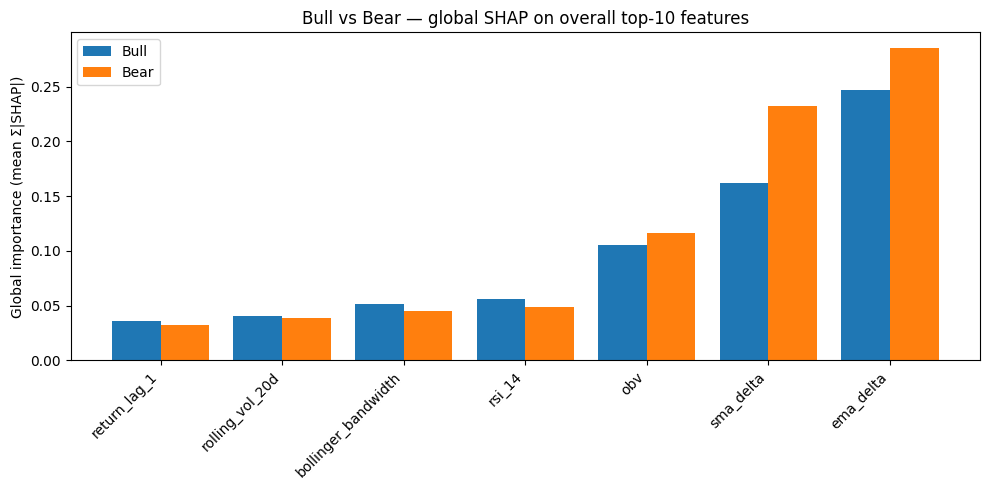

✅ RQ3 completed (global SHAP, plots, regime stability).


In [ ]:
# ---- Cell 5. Regime-wise SHAP stability (truth-based bull vs bear) ----

if "regime_true" in reg_df.columns:
    truth = reg_df["regime_true"].values
elif "RegimeLabel" in reg_df.columns:
    truth = reg_df["RegimeLabel"].values
elif "regime" in reg_df.columns:
    truth = reg_df["regime"].values
else:
    raise KeyError("No truth-based regime column found in test_regimes.csv")

bull_idx = (truth == 1)
bear_idx = ~bull_idx
assert bull_idx.shape[0] == X_test.shape[0], "Regime index length mismatch"

I_bull = shap_global(explainer, X_test[bull_idx]) if bull_idx.any() else np.zeros_like(I_all)
I_bear = shap_global(explainer, X_test[bear_idx]) if bear_idx.any() else np.zeros_like(I_all)

rho_reg   = spearman_rho(I_bull, I_bear)
jac10_reg = topk_jaccard(I_bull, I_bear, 10)

out_reg = pd.DataFrame({
    "metric": ["Spearman(bull,bear)", "Jaccard@10(bull,bear)"],
    "value":  [rho_reg,               jac10_reg]
})
out_reg.to_csv(os.path.join(RESULTS_ATTR, "rq3_shap_regime_stability.csv"), index=False)
print("\nRegime-wise stability:\n", out_reg)

# Plot: bull vs bear top-10 bars (based on overall top-10)
labels = [feat_names[i] for i in top_idx]
x = np.arange(len(labels))
plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, [I_bull[i] for i in top_idx], width=0.4, label="Bull")
plt.bar(x + 0.2, [I_bear[i] for i in top_idx], width=0.4, label="Bear")
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("Global importance (mean Σ|SHAP|)")
plt.title("Bull vs Bear — global SHAP on overall top-10 features")
plt.legend(); plt.tight_layout()
savefig(os.path.join(RESULTS_ATTR, "rq3_bull_vs_bear_top10.png"))
plt.close()

# Save per-feature vectors for appendix
pd.DataFrame({"feature": feat_names, "bull": I_bull, "bear": I_bear}) \
  .to_csv(os.path.join(RESULTS_ATTR, "rq3_shap_bull_bear_vectors.csv"), index=False)

# ---- End (perturbation-stability is deferred to RQ5 → RQ3b) ----
print(" RQ3 completed (global SHAP, plots, regime stability).")

/tmp/ipython-input-2897339678.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_last, X_explain[:, -1, :], feature_names=feat_names, show=True)


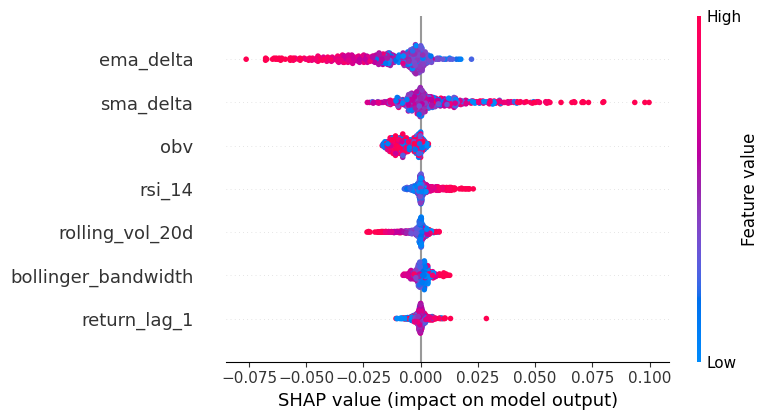

<Figure size 640x480 with 0 Axes>

In [ ]:
#beeswarm of all features (last time step) with feature values
shap.summary_plot(shap_last, X_explain[:, -1, :], feature_names=feat_names, show=True)
plt.tight_layout()
plt.savefig("shap_beeswarm.png", dpi=300)
plt.close()
